# Chapter 11 Ensemble models

In [42]:
# Environment variables
import os
from dotenv import load_dotenv

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning - scikit-learn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import auc, make_scorer, mean_absolute_error, mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

# Machine learning - XGBoost
import xgboost as xgb

# Machine learning - Bayesian optimization
from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Integer

# Deep learning - Keras/TensorFlow
import tensorflow as tf
import keras
from keras import initializers, Input, layers
from keras.constraints import non_neg
from keras.utils import to_categorical
from plot_keras_history import show_history

# Optimization
from cvxopt import matrix, solvers

# FRED API
from fredapi import Fred

In [2]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # for classification

In [25]:
# Recreate variables done in notebooks 4 and 5
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]

# Regression labels
y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features]
X_test = testing_sample[features]
y_test = testing_sample['R1M_Usd'].values

# Classification labels: up (1) if return > 0 else 0
y_c_train = training_sample['R1M_Usd_C'].values # classification target
y_c_test = testing_sample['R1M_Usd_C'].values

# For XGBoost model training on extreme values only
separation_mask = data_ml['date'] < separation_date

data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values

boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values

test_features_xgb=testing_sample[features_short] # Test sample => XGB format
test_matrix_xgb=xgb.DMatrix(test_features_xgb, label=y_test) # XGB format!

# Neural Network data preparation
NN_train_features = training_sample[features].values   # Training features
NN_train_labels = training_sample['R1M_Usd'].values    # Training labels
NN_test_features = testing_sample[features].values  # Testing features
NN_test_labels = testing_sample['R1M_Usd'].values   # Testing labels

In [4]:
# === Fitting model_NNs === #

# Penalized Regression
model_NN = ElasticNet(alpha=0.1, l1_ratio=0.1)
fit_pen_pred = model_NN.fit(X_train, y_train)

# Decision Tree Regressor
fit_tree = tree.DecisionTreeRegressor( # Definining the model_NN
  min_samples_split = 8000, # Min nb of obs required to continue splitting 
  max_depth = 3, # Maximum depth (i.e. tree levels)
  ccp_alpha = 0.000001, # complexity parameters
  min_samples_leaf = 3500 # Min nb of obs required in each terminal node (leaf)
)
fit_tree.fit(X, y) # Fitting the model_NN

# Random Forest Regressor
fit_RF = RandomForestRegressor(
    n_estimators = 40, # Nb of random trees
    criterion ='squared_error', # function to measure the quality of a split
    min_samples_split= 250, # Minimum size of terminal cluster
    bootstrap=True, # replacement
    max_features=30, # Nb of predictive variables for each tree
    max_samples=10000 # Size of (random) sample for each tree
)
fit_RF.fit(X_train, y_train) # Fitting the model_NN
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,]) # Prediction over the first 5 test instances

# XGBoost Regressor
train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!
mono_const="(0, 0, -1, 1, 0, -1, 0)" # Initialize the vector -- "-1" == decreasing, "+1" increasing 
# Decreasing in market cap -- mono_const[2]
# Increasing in past return -- mono_const[3]
# Decreasing in price-to-book -- mono_const[5]
params = {
    # General Booster Parameters
    'booster' : 'dart',         # Explicitly set to DART to enable 'rate_drop'
    'objective' : "reg:squarederror", # Objective function
    'eta' : 0.1,               # Learning rate
    
    # Tree Structure and Pruning
    'max_depth' : 4,            # Max depth of each tree
    'gamma' : 0.1,              # Penalization of number of leaves (pruning).
    'lambda' : 1.0,             # L2 regularization on leaf weights (w^2)
    'monotone_constraints' : mono_const, # Monotonicity constraints

    # Subsampling/Regularization
    'subsample' : 0.6,          # Train on random 60% of sample
    'colsample_bytree' : 0.7,   # Train on random 70% of predictors

    # DART Specific Parameters
    'rate_drop' : 0.1,          # Dropout rate for DART
    'skip_drop' : 0.5,          # Probability of skipping the dropout procedure for DART
}
fit_xgb =xgb.train(params, train_matrix_xgb)

# Neural Network Regressor
input_dimension = len(features_short)
model_NN = keras.Sequential([
    # Input layer
    Input(shape=(input_dimension,)), 
    
    # Dense layers
    layers.Dense(16, activation="relu"),  
    layers.Dense(8, activation="tanh"),
    layers.Dense(1)
])
model_NN.compile(optimizer='RMSprop', 
              loss='mse', 
              metrics=['MeanAbsoluteError'])
model_NN.fit(
            training_sample[features_short],
            y_train,
            batch_size=256,
            epochs = 10,
            validation_data=(testing_sample[features_short],y_test),
            verbose = True
)

Epoch 1/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - MeanAbsoluteError: 0.1174 - loss: 0.0500 - val_MeanAbsoluteError: 0.0667 - val_loss: 0.0342
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - MeanAbsoluteError: 0.0878 - loss: 0.0306 - val_MeanAbsoluteError: 0.0669 - val_loss: 0.0343
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - MeanAbsoluteError: 0.0875 - loss: 0.0305 - val_MeanAbsoluteError: 0.0664 - val_loss: 0.0342
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - MeanAbsoluteError: 0.0874 - loss: 0.0305 - val_MeanAbsoluteError: 0.0698 - val_loss: 0.0348
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - MeanAbsoluteError: 0.0874 - loss: 0.0305 - val_MeanAbsoluteError: 0.0672 - val_loss: 0.0343
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - MeanAbsoluteError: 0.0873 - loss: 0.0304 - val_MeanAbsoluteError: 0.0662 - val_loss: 0.0341
Epoch 7/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - MeanAbsoluteError: 0.0872 - loss: 0.0304 - val_MeanAbsoluteError: 0.06

## 11.1 Linear ensembles

In [5]:
err_pen_train = fit_pen_pred.predict(X_train)-training_sample['R1M_Usd']          # Reg.
err_tree_train = fit_tree.predict(training_sample[features])-training_sample['R1M_Usd']     # Tree
err_RF_train = fit_RF.predict(training_sample[features])-training_sample['R1M_Usd']         # RF
err_XGB_train = fit_xgb.predict(train_matrix_xgb)-training_sample.loc[boolean_quantile,'R1M_Usd']  # XGBoost (only on subset)
err_NN_train = model_NN.predict(training_sample[features_short])-training_sample['R1M_Usd'].values.reshape((-1,1))  # NN

# Align all errors to the same indices (only where XGB has predictions)
E = pd.DataFrame({
    'Pen_reg': err_pen_train.values[boolean_quantile],
    'Tree': err_tree_train.values[boolean_quantile],
    'RF': err_RF_train.values[boolean_quantile],
    'XGB': err_XGB_train.values,
    'NN': err_NN_train.flatten()[boolean_quantile]
})
E.corr()

6152/6152 ━━━━━━━━━━━━━━━━━━━━ 5s 880us/step


,Pen_reg,Tree,RF,XGB,NN
Pen_reg,1.000000,0.998561,0.996608,0.998835,0.996634
Tree,0.998561,1.000000,0.997545,0.998879,0.997584
RF,0.996608,0.997545,1.000000,0.997646,0.997134
XGB,0.998835,0.998879,0.997646,1.000000,0.998160
NN,0.996634,0.997584,0.997134,0.998160,1.000000


In [6]:
E.corr().mean()

Pen_reg    0.998128
Tree       0.998514
RF         0.997786
XGB        0.998704
NN         0.997902
dtype: float64

In [7]:
abs(E).mean() # Mean absolute error or columns of E 

Pen_reg    0.086510
Tree       0.086638
RF         0.086334
XGB        0.086526
NN         0.086915
dtype: float64

In [8]:
w_ensemble = np.linalg.inv((E.T.values@E.values))@np.ones(5) # Optimal weights
w_ensemble /= np.sum(w_ensemble)
w_ensemble

array([-1.42573886, -0.72245257,  1.19725784,  2.31661549, -0.3656819 ])

In [9]:
err_pen_test = fit_pen_pred.predict(X_test)-testing_sample['R1M_Usd']          # Reg.
err_tree_test = fit_tree.predict(testing_sample[features])-testing_sample['R1M_Usd']     # Tree
err_RF_test = fit_RF.predict(testing_sample[features])-testing_sample['R1M_Usd']         # RF
err_XGB_test = fit_xgb.predict(test_matrix_xgb)-testing_sample['R1M_Usd']                # XGBoost
err_NN_test = model_NN.predict(testing_sample[features_short])-testing_sample['R1M_Usd'].values.reshape((-1,1))  # NN
E_test= pd.concat([err_pen_test, err_tree_test,err_RF_test,err_XGB_test,pd.DataFrame(err_NN_test,index=testing_sample.index)], axis=1)   # E_test matrix
E_test = E_test.set_axis(['Pen_reg','Tree','RF','XGB','NN'], axis=1)                       # Names
abs(E_test).mean() # Mean absolute error or columns of E_test

2705/2705 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Pen_reg    0.065327
Tree       0.065773
RF         0.066501
XGB        0.065699
NN         0.066514
dtype: float64

In [10]:
err_EW_test = np.mean(np.abs(E_test.mean(axis=1))) # equally weight combination
print(f'equally weight combination: {err_EW_test}')

equally weight combination: 0.06568872297024521


In [11]:
err_opt_test =np.mean(np.abs(E_test.values@w_ensemble)) # Optimal unconstrained combination
print(f'Optimal unconstrained combination: {err_opt_test}')

Optimal unconstrained combination: 0.06808866083905384


In [12]:
E_test.corr()

,Pen_reg,Tree,RF,XGB,NN
Pen_reg,1.000000,0.998593,0.996210,0.998703,0.995788
Tree,0.998593,1.000000,0.997564,0.998942,0.997348
RF,0.996210,0.997564,1.000000,0.997566,0.997313
XGB,0.998703,0.998942,0.997566,1.000000,0.997787
NN,0.995788,0.997348,0.997313,0.997787,1.000000


In [13]:
sigma = E.T.values@E.values                           # Unscaled covariance matrix
nb_mods= 5                                            # Number of models
Q = 2*matrix(sigma, tc="d")                           # Symmetric quadratic-cost matrix
p = matrix(np.zeros(nb_mods),tc="d")                  # Quadratic-cost vector
G = matrix(-np.eye(nb_mods), tc="d")                  # Linear inequality constraint matrix
h = matrix(np.zeros(nb_mods), tc="d")                 # Linear inequality constraint vector
A = matrix(np.ones(nb_mods), (1, nb_mods))            # matrix for linear equality constraint
b = matrix(1.0)                                       # vector for linear equality constraint
w_const=solvers.qp(Q, p, G, h, A, b)                  # Solution
print(w_const['x']) # Solution

     pcost       dcost       gap    pres   dres
 0:  5.8845e+03  5.8895e+03  3e+01  5e+00  7e+00
 1:  5.8869e+03  5.9016e+03  1e+01  2e+00  3e+00
 2:  5.9258e+03  5.9293e+03  1e+01  4e-01  5e-01
 3:  5.9318e+03  5.9302e+03  2e+00  2e-16  5e-12
 4:  5.9308e+03  5.9307e+03  8e-02  2e-16  3e-12
 5:  5.9307e+03  5.9307e+03  8e-04  3e-17  5e-12
Optimal solution found.
[ 1.95e-06]
[ 2.14e-06]
[ 9.05e-01]
[ 9.49e-02]
[ 4.20e-05]



## 11.2 Stacked ensembles

In [32]:
model_stack = keras.Sequential([
    # Input layer
    Input(shape=(nb_mods,)), 
    
    # Dense layers
    layers.Dense(8, activation="relu"),  
    layers.Dense(4, activation="tanh"),
    layers.Dense(1)
])

In [33]:
model_stack.compile(optimizer='RMSprop',                        # Optimisation method (weight updating)
              loss='mse',                                       # Loss function
              metrics=['MeanAbsoluteError'])                    # Output metric
model_stack.summary()  

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - MeanAbsoluteError: 0.0865 - loss: 0.0302 - val_MeanAbsoluteError: 0.0669 - val_loss: 0.0342
Epoch 2/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanAbsoluteError: 0.0867 - loss: 0.0301 - val_MeanAbsoluteError: 0.0674 - val_loss: 0.0342
Epoch 3/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MeanAbsoluteError: 0.0868 - loss: 0.0301 - val_MeanAbsoluteError: 0.0672 - val_loss: 0.0342
Epoch 4/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - MeanAbsoluteError: 0.0867 - loss: 0.0301 - val_MeanAbsoluteError: 0.0674 - val_loss: 0.0342
Epoch 5/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - MeanAbsoluteError: 0.0867 - loss: 0.0300 - val_MeanAbsoluteError: 0.0676 - val_loss: 0.0342
Epoch 6/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanAbsoluteError: 0.0868 - loss: 0.0300 - val_MeanAbsoluteError: 0.0681 - val_loss: 0.0342
Epoch 7/12
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - MeanAbsoluteError: 0.0867 - loss: 0.0300 - val_MeanAbsoluteError: 0.06

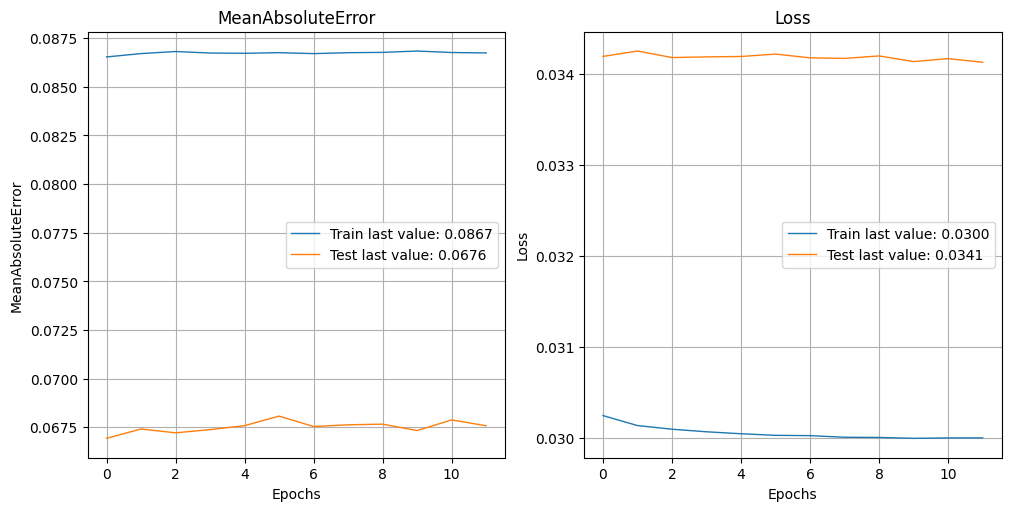

In [34]:
y_tilde = E.values + np.tile(training_sample['R1M_Usd'].values.reshape(-1, 1), nb_mods)    # Train preds
y_test = E_test.values + np.tile(testing_sample['R1M_Usd'].values.reshape(-1, 1), nb_mods) # Testing
fit_NN_stack  = model_stack.fit(y_tilde,                            # Train features
                          NN_train_labels,                          # Train labels
                          batch_size=512,                           # Train parameters
                          epochs=12,                                # Train parameters
                          verbose=1,                                # Show messages
                          validation_data=(y_test,NN_test_labels))  # Test features & labels
show_history(fit_NN_stack )                                         # Show training plot

MAE seems incorrect. I tried investigated why train MAE > test MAE but i don't find the root problem.

I found this about volatility but don't find the root cause:

In [37]:
# Calculate volatility (standard deviation) of the target in Train vs Test
train_volatility = np.std(y_train)
test_volatility = np.std(y_test)

print(f"Training Data Volatility (Std Dev): {train_volatility:.4f}")
print(f"Testing Data Volatility (Std Dev): {test_volatility:.4f}")

# Calculate the ratio
print(f"Ratio (Train / Test): {train_volatility / test_volatility:.2f}")

Training Data Volatility (Std Dev): 0.1748
Testing Data Volatility (Std Dev): 0.0121
Ratio (Train / Test): 14.43


## 11.3 Extensions

### 11.3.1 Exogenous variables

In [47]:
# # === Retrieve macro conditions from FRED API === #

# # Retrieve macro conditions from FRED API and merge to testing errors
# load_dotenv()
# api_key = os.getenv("FRED_API_KEY")
# fred = Fred(api_key=api_key)

# # Time window based on test sample
# start_date = pd.to_datetime(testing_sample['date']).min()
# end_date = pd.to_datetime(testing_sample['date']).max()

# CPI_ID = 'CPIAUCSL'
# TS_ID = 'T10Y2YM'

# # --- 1. Fetch series ---
# # CPI (monthly)
# cpi_series = fred.get_series(CPI_ID, observation_start=start_date, observation_end=end_date)
# cpi_df = cpi_series.dropna().to_frame().reset_index()
# cpi_df.columns = ['date', 'CPIAUCSL']
# cpi_df['date'] = pd.to_datetime(cpi_df['date'])

# # Term spread (daily)
# ts_series = fred.get_series(TS_ID, observation_start=start_date, observation_end=end_date)
# ts_df = ts_series.dropna().to_frame().reset_index()
# ts_df.columns = ['date', 'termspread']
# ts_df['date'] = pd.to_datetime(ts_df['date'])

# # --- 2. Monthly alignment at month START (first day) ---
# # Create Index as first day of each month for joining
# cpi_df['Index'] = cpi_df['date'] + pd.offsets.MonthBegin(-1)
# cpi_df = cpi_df.sort_values(['Index', 'date'])
# cpi_m = (
#     cpi_df.groupby('Index', as_index=False)
#           .first()  # keep earliest obs in month; retains 'date' and 'CPIAUCSL'
# )
# cpi_m['inflation'] = cpi_m['CPIAUCSL'].pct_change()

# ts_df['Index'] = ts_df['date'] + pd.offsets.MonthBegin(-1)
# ts_df = ts_df.sort_values(['Index', 'date'])
# ts_m = (
#     ts_df.groupby('Index', as_index=False)
#         .first()[['Index', 'termspread']]  # earliest obs per month
# )

# # Compose macro conditions DataFrame similar to macro_cond.csv structure
# macro_cond = cpi_m.merge(ts_m, on='Index', how='left')  # columns: Index, date, CPIAUCSL, inflation, termspread
# macro_cond.to_csv('../data/processed/macro_cond.csv', index=False)

In [50]:
macro_cond = pd.read_csv("../data/processed/macro_cond.csv")                            # Term Spred, Inflation and Consumer Price Index
macro_cond["Index"] = pd.to_datetime(macro_cond["date"]) + pd.offsets.MonthBegin(-1)    # Change date to first day of month to join/merge
ens_data = pd.DataFrame()
ens_data['date'] = testing_sample['date'].values
ens_data['err_NN_test'] = np.asarray(err_NN_test).ravel()                               # errors from previous section
ens_data['Index'] = pd.to_datetime(ens_data['date']) + pd.offsets.MonthBegin(-1)
ens_data = pd.merge(ens_data, macro_cond, how='left', on='Index')
ens_data.head()

,date_x,err_NN_test,Index,date_y,CPIAUCSL,inflation,termspread
0,2015-03-31,-0.111155,2015-03-01,2015-04-01,236.222,0.001042,1.40
1,2015-04-30,0.171520,2015-04-01,2015-05-01,237.001,0.003298,1.59
2,2015-05-31,0.252310,2015-05-01,2015-06-01,237.657,0.002768,1.67
3,2015-06-30,0.478089,2015-06-01,2015-07-01,238.034,0.001586,1.65
4,2015-07-31,-0.512243,2015-07-01,2015-08-01,238.033,-0.000004,1.47


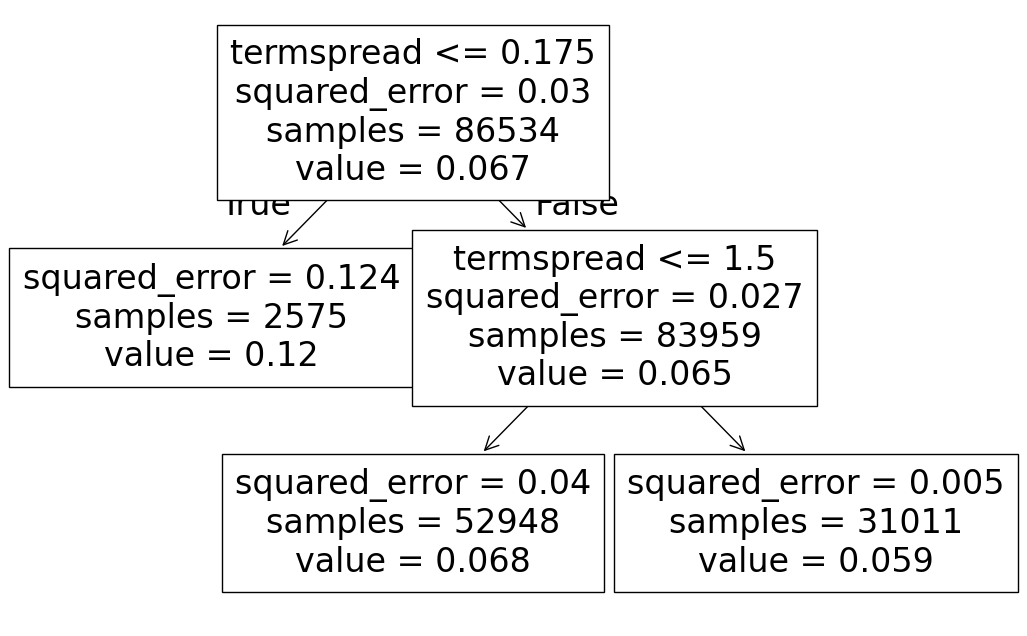

In [51]:
X_ens = ens_data[['inflation','termspread']]                                         # Training macro features
y_ens = abs(ens_data['err_NN_test'])                                                 # Label, here error from previous section 
fit_ens  = tree.DecisionTreeRegressor(                                               # Definining the model
  max_depth = 2,                                                                     # Maximum depth (i.e. tree levels)
  ccp_alpha=0.00001                                                                  # complexity parameters
        )
fit_ens.fit(X_ens, y_ens)                                                            # Fitting the model
fig, ax = plt.subplots(figsize=(13, 8))                                              # resizing
tree.plot_tree(fit_ens ,feature_names=X_ens.columns.values, ax=ax)                   # Plot the tree
plt.show()

### 11.3.2 Shrinking inter-model correlations

In [65]:
training_sample_2007 = training_sample.loc[training_sample.index[(
    training_sample['date'] > '2006-12-31') & (training_sample['date'] < '2008-01-01')].tolist()]
training_sample_2009 = training_sample.loc[training_sample.index[(
    training_sample['date'] > '2008-12-31') & (training_sample['date'] < '2010-01-01')].tolist()]
training_sample_2011 = training_sample.loc[training_sample.index[(
    training_sample['date'] > '2010-12-31') & (training_sample['date'] < '2012-01-01')].tolist()]
training_sample_2012 = training_sample.loc[training_sample.index[(
    training_sample['date'] > '2011-12-31') & (training_sample['date'] < '2013-01-01')].tolist()]

In [66]:
y_ens_2007 = training_sample_2007['R1M_Usd'].values                                 # Dep. var.
x_ens_2007 = training_sample_2007[features].values                                  # Predictors
model_2007 = ElasticNet(alpha=0.1, l1_ratio=0.1)                                    # Model
fit_ens_2007=model_2007.fit(x_ens_2007,y_ens_2007)                                  # fitting the model
err_ens_2007 = fit_ens_2007.predict(X_test)-testing_sample['R1M_Usd']     # Pred. errs

d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [67]:
fit_ens_2009 = RandomForestRegressor(n_estimators = 40, # Nb of random trees
criterion ='squared_error', # function to measure the quality of a split
min_samples_split= 250, # Minimum size of terminal cluster
bootstrap=True, # replacement
max_features=30, # Nb of predictive variables for each tree
max_samples=4000 # Size of (random) sample for each tree
)
fit_ens_2009.fit(training_sample_2009[features].values,training_sample_2009['R1M_Usd'].values ) # Fitting the model
err_ens_2009=fit_ens_2009.predict(pd.DataFrame(X_test))-testing_sample['R1M_Usd'] # Pred. errs

d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [68]:
train_features_xgb_2011=training_sample_2011[features_short].values # Independent variables
train_label_xgb_2011=training_sample_2011['R1M_Usd'].values # Dependent variable
train_matrix_xgb_2011=xgb.DMatrix(train_features_xgb_2011, label=train_label_xgb_2011) # XGB format!

params={'eta' : 0.3,                          # Learning rate
  'objective' : "reg:squarederror",     # Objective function
  'max_depth' : 4,                      # Maximum depth of trees
  'subsample' : 0.6,                    # Train on random 60% of sample
  'colsample_bytree' : 0.7,             # Train on random 70% of predictors
  'lambda' : 1,                         # Penalisation of leaf values
  'gamma' : 0.1}                        # Penalisation of number of leaves
fit_ens_2011 =xgb.train(params, train_matrix_xgb_2011, num_boost_round=18) # Number of trees used
err_ens_2011=fit_ens_2011.predict(test_matrix_xgb)-testing_sample['R1M_Usd'] # Pred. errs

In [69]:
model = keras.Sequential([
    # Input layer
    Input(shape=(len(features),)), 
    
    # Dense layers
    layers.Dense(16, activation="relu"),  
    layers.Dense(8, activation="tanh"),
    layers.Dense(1)
])

model.compile(optimizer='RMSprop', 
              loss='mse', 
              metrics=['MeanAbsoluteError'])
              
model.summary()
fit_ens_2012 = model.fit(
            training_sample_2012[features].values,                  # Training features
            training_sample_2012['R1M_Usd'].values,                 # Training labels
            batch_size=128,                                         # Training parameters
            epochs = 9,                                             # Training parameters
            verbose = True                                          # Show messages
)

err_ens_2012=model.predict(X_test)-testing_sample['R1M_Usd'].values.reshape((-1,1)) # Pred. errs

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 16)             │         1,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanAbsoluteError: 0.1156 - loss: 0.0397
Epoch 2/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0652 - loss: 0.0137
Epoch 3/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0625 - loss: 0.0132
Epoch 4/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0616 - loss: 0.0130
Epoch 5/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanAbsoluteError: 0.0610 - loss: 0.0129
Epoch 6/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0609 - loss: 0.0129
Epoch 7/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanAbsoluteError: 0.0606 - loss: 0.0128
Epoch 8/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0605 - loss: 0.0128
Epoch 9/9
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.0603 - loss: 0.0128
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


## 11.4 Integrated ensemble with 3 neural networks

In [ ]:
# Split features into 3 groups
n_features = len(features)
group_size = n_features // 3

feature_group_1 = features[:group_size]
feature_group_2 = features[group_size:2*group_size]
feature_group_3 = features[2*group_size:]

print(f"Feature Group 1: {len(feature_group_1)} features")
print(f"Feature Group 2: {len(feature_group_2)} features")
print(f"Feature Group 3: {len(feature_group_3)} features")

# Prepare training and testing data for each group
X_train_1 = training_sample[feature_group_1].values
X_train_2 = training_sample[feature_group_2].values
X_train_3 = training_sample[feature_group_3].values

X_test_1 = testing_sample[feature_group_1].values
X_test_2 = testing_sample[feature_group_2].values
X_test_3 = testing_sample[feature_group_3].values


In [ ]:
# === Build 3 Expert Networks using Functional API ===

# Input layers for each group
input_1 = Input(shape=(len(feature_group_1),), name='input_group_1')
input_2 = Input(shape=(len(feature_group_2),), name='input_group_2')
input_3 = Input(shape=(len(feature_group_3),), name='input_group_3')

# Expert Network 1
x1 = layers.Dense(16, activation='relu', name='expert1_dense1')(input_1)
x1 = layers.Dense(8, activation='relu', name='expert1_dense2')(x1)
output_1 = layers.Dense(1, activation='sigmoid', name='expert1_output')(x1)

# Expert Network 2
x2 = layers.Dense(16, activation='relu', name='expert2_dense1')(input_2)
x2 = layers.Dense(8, activation='relu', name='expert2_dense2')(x2)
output_2 = layers.Dense(1, activation='sigmoid', name='expert2_output')(x2)

# Expert Network 3
x3 = layers.Dense(16, activation='relu', name='expert3_dense1')(input_3)
x3 = layers.Dense(8, activation='relu', name='expert3_dense2')(x3)
output_3 = layers.Dense(1, activation='sigmoid', name='expert3_output')(x3)

# Meta-Learner: Aggregate the 3 outputs
concatenated = layers.Concatenate(name='concatenate')([output_1, output_2, output_3])
meta_hidden = layers.Dense(8, activation='relu', name='meta_hidden')(concatenated)
final_output = layers.Dense(1, activation='sigmoid', name='final_output')(meta_hidden)

# Create the model
model_ensemble_3nn = keras.Model(
    inputs=[input_1, input_2, input_3],
    outputs=final_output,
    name='Ensemble_3NN_Classifier'
)

model_ensemble_3nn.summary()


In [ ]:
# Compile the model
model_ensemble_3nn.compile(
    optimizer='RMSprop',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

# Train the model
history_3nn = model_ensemble_3nn.fit(
    [X_train_1, X_train_2, X_train_3],                    # Training inputs (3 groups)
    y_c_train,                                            # Training labels (classification)
    batch_size=256,
    epochs=15,
    validation_data=([X_test_1, X_test_2, X_test_3], y_c_test),
    verbose=1
)

show_history(history_3nn)


In [ ]:
# === Evaluate on Testing Sample ===

# Generate predictions
y_pred_proba = model_ensemble_3nn.predict([X_test_1, X_test_2, X_test_3])
y_pred_class = (y_pred_proba > 0.5).astype(int).flatten()

# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_c_test, y_pred_class)
precision = precision_score(y_c_test, y_pred_class)
recall = recall_score(y_c_test, y_pred_class)
f1 = f1_score(y_c_test, y_pred_class)

print(f"Ensemble 3NN Classifier Performance on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_c_test, y_pred_class)
print(f"\nConfusion Matrix:")
print(cm)

# ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve, auc as sklearn_auc

roc_auc = roc_auc_score(y_c_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_c_test, y_pred_proba)
roc_curve_auc = sklearn_auc(fpr, tpr)

print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_curve_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Ensemble 3NN Classifier')
ax.legend(loc="lower right")
plt.show()


In [75]:
E_subtraining = pd.concat([err_ens_2007, err_ens_2009,err_ens_2011,pd.DataFrame(err_ens_2012,index=testing_sample.index)], axis=1)         # E_subtraining matrix
E_subtraining = E_subtraining.set_axis(['err_ens_2007','err_ens_2009','err_ens_2011','err_ens_2012'], axis=1)   # Names
E_subtraining.corr()  

,err_ens_2007,err_ens_2009,err_ens_2011,err_ens_2012
err_ens_2007,1.000000,0.974317,0.798570,0.997828
err_ens_2009,0.974317,1.000000,0.784128,0.977414
err_ens_2011,0.798570,0.784128,1.000000,0.798386
err_ens_2012,0.997828,0.977414,0.798386,1.000000


In [76]:
E_subtraining.corr().mean()


err_ens_2007    0.942679
err_ens_2009    0.933965
err_ens_2011    0.845271
err_ens_2012    0.943407
dtype: float64

## 11.4 Exercise
Build an integrated ensemble on top of 3 neural networks trained entirely with Keras. Each network obtains one third of predictors as input. The three networks yield a classification (yes/no or buy/sell). The overarching network aggregates the three outputs into a final decision. Evaluate its performance on the testing sample. Use the functional API.